## Assignment 2: Adversarial Training

This assignment requires you to create adversarial examples. You will do adversarial training, i.e., train the model with sets of adversarial examples you generated and evaluate the performances of the model on test sets.

### What is Adversarial Training?
Adversarial training is a machine learning technique to improve models' robustness by training them on adversarial examples. Adversarial examples are input data that has been intentionally modified to cause the model to misclassify or produce an incorrect output. 

When a model is trained using adversarial examples, it becomes more resilient to adversarial attacks and is able to better identify and classify input data that may have been modified or corrupted. This may lead to improved performance of the model in real-world scenarios where the input data may not always be perfect.

However, adversarial training can also have some negative impacts on ML models. For example, it can lead to overfitting, where the model becomes too specialized to the particular adversarial examples used in training and is unable to generalize well to new examples. Additionally, adversarial training can increase the computational requirements of training the model due to the need for generating adversarial examples.

Overall, while adversarial training can improve the robustness of ML models, it is important to carefully consider its potential benefits and drawbacks and to evaluate the trade-offs in terms of model performance and computational requirements. The following are the steps involved in adversarial training:

1. Generate adversarial examples: In the first step, we generate adversarial examples by perturbing the original data points in such a way that the modifications are small and not noticeable to humans but are enough to cause misclassification by the neural network.

2. Train on adversarial examples: In the second step, we train the neural network on adversarial examples in addition to the original training data. This helps to improve the network's ability to recognize and classify adversarial examples correctly.

3. Evaluate performance: In the third step, we evaluate the performance of the network on both the original and adversarial test data. This helps to determine if the adversarial training has improved the network's robustness against adversarial attacks.

Overall, adversarial training is a powerful technique that can help improve the security and reliability of deep neural networks.

In this Homework, you will run different adversarial training algorithms on the ResNet18 model with the adversarial examples, and evaluating the model performances on test data. The goal is to get experience in generating adversarial examples and train the model with these examples, i.e., adversarial training.

We have provided the model architecture ($\texttt{model.py}$) and some pre-defined functions ($\texttt{utils.py}$) so you can import and use them directly in the notebook.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import random
import numpy as np
from model import ResNet18
from utils import trades_loss, mixup_data, mixup_criterion, make_dataloader, eval_test

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

### Q1 (20 points)
Use the following parameters to define the LinfPGDAttack():

- Epsilon: 8/255
- PGD Steps: 10
- PGD Step Size: 0.003

In [2]:
class LinfPGDAttack(nn.Module):
    def __init__(self, model, epsilon, steps=10, step_size=0.003):
        super().__init__()
        self.model = model
        self.epsilon = epsilon
        self.steps = steps
        self.step_size = step_size

    def perturb(self, x_natural:torch.Tensor, y:torch.Tensor) -> torch.Tensor:
        """
        Computes the gradient of the cross-entropy loss with respect to the input
        image `x_adv` and updates the image based on the gradient direction. The 
        perturbation is clipped to ensure it stays within a specified epsilon range
        and is finally clamped to ensure pixel values are valid. 
        
        The resulting perturbed image is returned.
        """
        # *********** Your code starts here *********** 
        
        cross_entropy = torch.nn.CrossEntropyLoss() # wrapper class whose forward pass uses F.cross_entropy
        x_adv = x_natural.detach().clone() # need to keep a clean version of x_natural for later comparison
        x_adv.requires_grad_() # ensure that the backwards pass will keep track of the gradient wrt the input
        
        for _ in range(self.steps):
            
            with torch.enable_grad(): # ensure gradients are being computed 
                loss = cross_entropy(input=self.model(x_adv), target=y) # compute loss between models prediction on x_adv and label y
                loss.backward() # backward pass to compute the gradient of the loss 

            x_adv.data += self.step_size * torch.sign(x_adv.grad) # update pixels of x_adv in direction of greatest asscent on the loss landscape        
            eta = torch.clamp(x_adv.data - x_natural.data, min=-self.epsilon, max=self.epsilon) # ensure diff between x_natural and x_adv within the epsilon box (since Linf norm) for all dims
            x_adv.data = torch.clamp(x_natural.data + eta, min=0, max=1) # ensure that the image is well defined after the perterbation
        
        # *********** Your code ends here *************
        return x_adv.detach()

    def forward(self, x_natural, y):

        x_adv = self.perturb(x_natural, y)
        return x_adv

There are many implementations of adversarial training; in this assignment, we ask you to evalaute which training algorithm can make the model more robust to LinfPGDAttack().

In [3]:
def train_ep(model, train_loader, mode, pgd_attack, optimizer, criterion, epoch, batch_size, device):
    model.train()
    model.to(device)
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        if mode == 'normal':
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        elif mode == 'adv_train': # [Ref] https://arxiv.org/abs/1706.06083
            model.eval() # Q --> dont we need to compute the gradients for the attack? 
            adv_x = pgd_attack(inputs, targets)
            model.train()

            optimizer.zero_grad()
            outputs = model(adv_x)
            loss = criterion(outputs, targets)

        elif mode == 'adv_train_trades': # [Ref] https://arxiv.org/abs/1901.08573
            optimizer.zero_grad()
            loss = trades_loss(model=model, x_natural=inputs, y=targets, optimizer=optimizer)
            
        elif mode == 'adv_train_mixup': # [Ref] https://arxiv.org/abs/1710.09412
            model.eval()
            benign_inputs, benign_targets_a, benign_targets_b, benign_lam = mixup_data(inputs, targets)            
            adv_x = pgd_attack(inputs, targets)
            adv_inputs, adv_targets_a, adv_targets_b, adv_lam = mixup_data(adv_x, targets)
            
            model.train()
            optimizer.zero_grad()
            
            benign_outputs = model(benign_inputs)
            adv_outputs = model(adv_inputs)
            loss_1 = mixup_criterion(criterion, benign_outputs, benign_targets_a, benign_targets_b, benign_lam)
            loss_2 = mixup_criterion(criterion, adv_outputs, adv_targets_a, adv_targets_b, adv_lam)
            
            loss = (loss_1 + loss_2) / 2

        else:
            print("No training mode specified.")
            raise ValueError()

        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{:05d}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(inputs), len(train_loader) * batch_size,
                       100. * (batch_idx + 1) / len(train_loader), loss.item()))

In [4]:
def train(model, train_loader, val_loader, pgd_attack,
          mode='natural', epochs=25, batch_size=256, learning_rate=0.1, momentum=0.9, weight_decay=2e-4,
          checkpoint_path='model1.pt', device='cpu'):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    best_acc = 0
    for epoch in range(epochs):
        # training
        train_ep(model, train_loader, mode, pgd_attack, optimizer, criterion, epoch, batch_size, device)

        # evaluate clean accuracy
        test_loss, test_acc = eval_test(model, val_loader, device)

        # remember best acc@1 and save checkpoint
        is_best = test_acc > best_acc
        best_acc = max(test_acc, best_acc)

        # save checkpoint if is a new best
        if is_best:
            torch.save(model.state_dict(), checkpoint_path)
        print('================================================================')

### Q2 (40 points)
Use the four training modes ("natural", "adv_train", "adv_train_trades", and "adv_train_mixup") to obtain four models, and save them as $\texttt{model1.pt}$, $\texttt{model2.pt}$, $\texttt{model3.pt}$, and $\texttt{model4.pt}$, respectively.

When calculating your losses, you may encounter Nan. In this case, you may consider adjusting the `learning rate` to solve the problem.

In [5]:
# define parameters
batch_size = 256
data_path = "../data" # directory of the data
epsilon = 8/255
steps = 10
epochs = 25

# create data loader
train_loader, val_loader = make_dataloader(data_path, batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
training_mode = "normal"

# Write your code here

# conduct normal training of the model on Cifar-10
# train(model=ResNet18(num_classes=10), train_loader=train_loader, val_loader=val_loader, pgd_attack=None, mode=training_mode, epochs=epochs, batch_size=256, checkpoint_path="model1_normal.pt", device='cuda:0')

In [7]:
training_mode = "adv_train"
model2 = ResNet18(num_classes=10) # randomly initilized model
pgd_attack = LinfPGDAttack(model=model2, epsilon=epsilon) # in adverserial training, model is attacking itself. This is the white box attack

# train(model=model2, train_loader=train_loader, val_loader=val_loader, pgd_attack=pgd_attack, mode=training_mode, epochs=epochs, batch_size=256, checkpoint_path="model2_adv_train.pt", device='cuda:0')

In [8]:
training_mode = "adv_train_trades"
model3 = ResNet18(num_classes=10) # randomly initilized model
pgd_attack = LinfPGDAttack(model=model3, epsilon=epsilon) # in adverserial training, model is attacking itself. This is the white box attack

# train(model=model3, train_loader=train_loader, val_loader=val_loader, pgd_attack=pgd_attack, mode=training_mode, epochs=epochs, batch_size=256, checkpoint_path="model3_adv_train_trades.pt", device='cuda:0')

In [9]:
training_mode = "adv_train_mixup"
model4 = ResNet18(num_classes=10) # randomly initilized model
pgd_attack = LinfPGDAttack(model=model4, epsilon=epsilon) # in adverserial training, model is attacking itself. This is the white box attack

# train(model=model4, train_loader=train_loader, val_loader=val_loader, pgd_attack=pgd_attack, mode=training_mode, epochs=epochs, batch_size=256, checkpoint_path="model4_adv_train_mixup.pt", device='cuda:0')

### Q3 (20 points)
Use eval_robust() to evaluate each model's robustness against LinfPGDAttack().

In [10]:
from utils import eval_robust
# *********** Your code starts here ***********
# robustness from model1

_, val_loader = make_dataloader(data_path, batch_size)

model1_state = torch.load("/home/andrew/hw2DL/89-Hw2/model1_normal.pt")
model1 = ResNet18(num_classes=10)
model1.load_state_dict(model1_state)
model1.to(device)

pgd_attack = LinfPGDAttack(model=model1, epsilon=epsilon) # want the model to be attacking itself! This is the white box attack; we know the models gradient
robust_loss, robust_acc = eval_robust(model=model1, test_loader=val_loader, pgd_attack=pgd_attack)


# *********** Your code ends here *************
print(f"Robustness for our normally trained resnet model: {robust_acc}%")

Files already downloaded and verified
Files already downloaded and verified
LinfPGD Attack: Average loss: 0.1101, Robust Accuracy: 1/10000 (0%)
Robustness for our normally trained resnet model: 0.01%


In [10]:
from utils import eval_robust
# *********** Your code starts here ***********
# robustness from model2 (adverserial training)

_, val_loader = make_dataloader(data_path, batch_size)

model2_state = torch.load("model2.adv_train.pt*")
model2 = ResNet18(num_classes=10)
model2.load_state_dict(model2_state)
model2.to(device)


pgd_attack = LinfPGDAttack(model=model2, epsilon=epsilon)
robust_loss, robust_acc = eval_robust(model=model2, test_loader=val_loader, pgd_attack=pgd_attack)


# *********** Your code ends here *************
print(f"Robustness for our adverserially trained resnet model: {robust_acc}%")

Files already downloaded and verified
Files already downloaded and verified
LinfPGD Attack: Average loss: 0.0058, Robust Accuracy: 4479/10000 (45%)
Robustness for our adverserially trained resnet model: 44.79%


In [14]:
from utils import eval_robust
# *********** Your code starts here ***********
# robustness from model 3 (adverserial training)

_, val_loader = make_dataloader(data_path, batch_size)

model3_state = torch.load("model3_adv_train_trades.pt")
model3 = ResNet18(num_classes=10)
model3.load_state_dict(model3_state)
model3.to(device)


pgd_attack = LinfPGDAttack(model=model3, epsilon=epsilon)
robust_loss, robust_acc = eval_robust(model=model3, test_loader=val_loader, pgd_attack=pgd_attack)

# *********** Your code ends here *************
print(f"Robustness for our adv_train_trades resnet model: {robust_acc}%")

Files already downloaded and verified
Files already downloaded and verified
LinfPGD Attack: Average loss: 0.0067, Robust Accuracy: 3837/10000 (38%)
Robustness for our adv_train_trades resnet model: 38.37%


In [12]:
from utils import eval_robust
# *********** Your code starts here ***********
# robustness from model 3 (adverserial training)

_, val_loader = make_dataloader(data_path, batch_size)

model4_state = torch.load("model4.adv_train_mixup.pt*")
model4 = ResNet18(num_classes=10)
model4.load_state_dict(model4_state)
model4.to(device)


pgd_attack = LinfPGDAttack(model=model4, epsilon=epsilon)
robust_loss, robust_acc = eval_robust(model=model4, test_loader=val_loader, pgd_attack=pgd_attack)

# *********** Your code ends here *************
print(f"Robustness for our adv_train_mixupresnet model: {robust_acc}%")

Files already downloaded and verified
Files already downloaded and verified
LinfPGD Attack: Average loss: 0.0065, Robust Accuracy: 3917/10000 (39%)
Robustness for our adv_train_mixupresnet model: 39.17%


### Q4 (10 points)
Visualize 10 adversarial examples from (with ground truth labels and model's predictions) from the model having best robust accuarcy.

In [13]:
# *********** Your code starts here ***********
"""
My model 2 has the best robustness accuracy. 

To generate 10 adverserial examples:
- Keep a list of tuples containing adv_examples = (adv_x, y_hat, x, y). While this list is less than 10:
- Load in the 4th model weights into a restnet module
- Loop over the evaluation set
- Compute a batch of adverserial examples from the model with the base attacker model
- Compute the predictions on the adverserial examples
- Get the indexs of where the predictions on the adverserial examples is different than the ground truth label
- Append examples to the tracker of adv_examples
"""

def generate_adverserial_examples(attacker, model, val_loader, device="cpu"):
    
    adv_examples = [] # container to hold adverserial examples
    model.to(device) # send model to device; modifies the module in place
    count = 0
    
    with torch.no_grad(): # only computing forward passes wrt model
        
        for X, y in val_loader: # X is batch of images; y is vector of labels for each image
            
            X, y = X.to(device), y.to(device) # pass batch to device; .to(device) for tensors returns a new tensor
            X_adv = attacker(X, y) # computing adverserial examples for each element in batch X
            logits = model(X_adv) # forward pass to compute logits for adv examples
            yhat = torch.argmax(logits, dim=1) # compute prediction for each examples in batch
            mask = torch.bitwise_not((yhat == y)) # binary mask for indexs where the model incorrectly labeled x_adv
            
            sucsessful_x = X[mask].to('cpu')
            sucsessful_x_adv = X_adv[mask].to('cpu') 
            sucsessful_y = y[mask].to('cpu')
            sucsessful_yhat = yhat[mask].to('cpu')

            adv_examples.append((sucsessful_x, sucsessful_x_adv, sucsessful_y, sucsessful_yhat))

            count += len(sucsessful_y)

            if count >= 10: 
                print(f"Found at least 10 adverserial examples")
                break

    return adv_examples

_, val_loader = make_dataloader(data_path, batch_size)

best_model_state = torch.load("model2.adv_train.pt*") # WILL WANT TO UPDATE WHICH MODEL IS THE BEST AFTER THE RESULTS
best_model = ResNet18(num_classes=10)
best_model.load_state_dict(best_model_state)
best_model.to(device)

pgd_attacker = LinfPGDAttack(model=best_model, epsilon=epsilon)
adv_examples = generate_adverserial_examples(attacker=pgd_attacker, model=best_model, val_loader=val_loader, device="cuda:0")

# *********** Your code ends here *************

Files already downloaded and verified
Files already downloaded and verified
Found at least 10 adverserial examples


Files already downloaded and verified


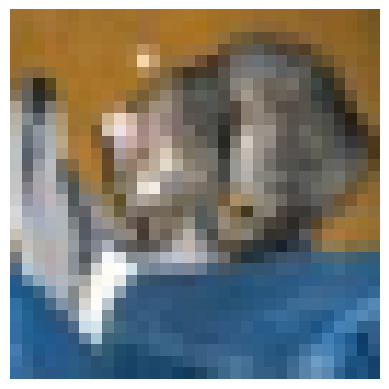

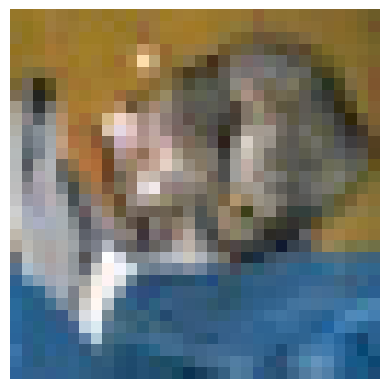

Label of the original example: cat
Label of the adverserial example: dog


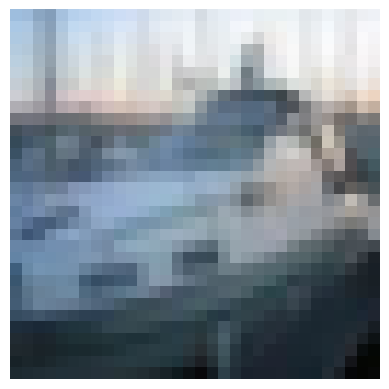

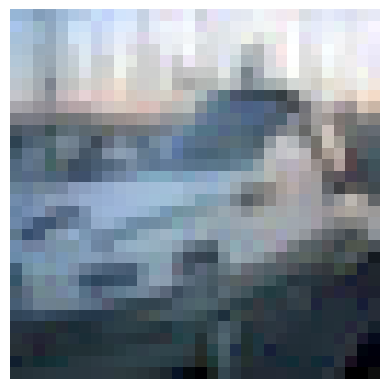

Label of the original example: ship
Label of the adverserial example: automobile


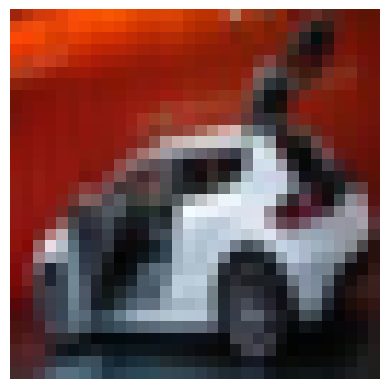

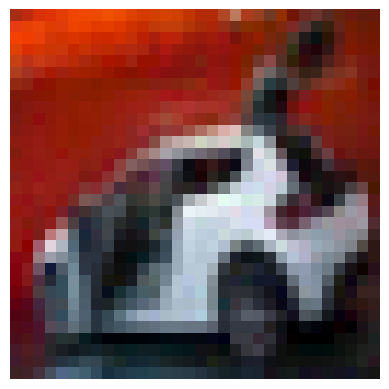

Label of the original example: automobile
Label of the adverserial example: dog


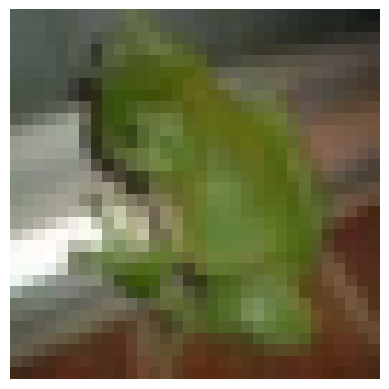

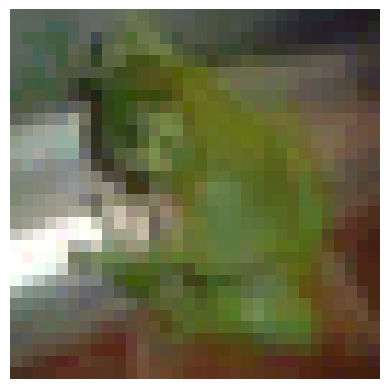

Label of the original example: frog
Label of the adverserial example: deer


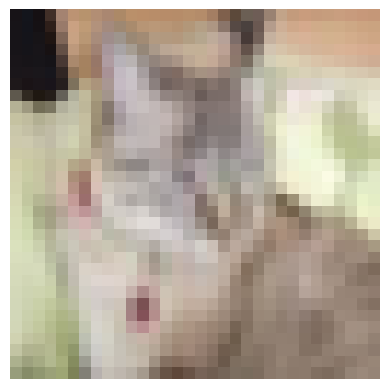

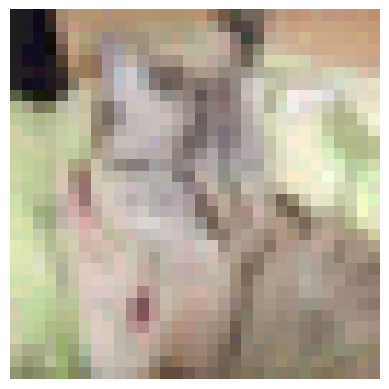

Label of the original example: cat
Label of the adverserial example: dog


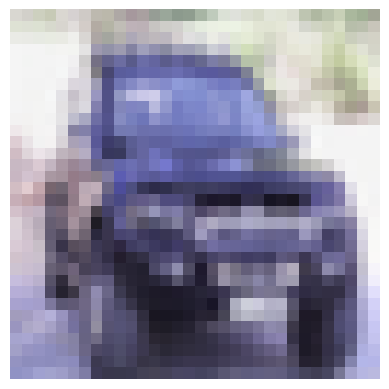

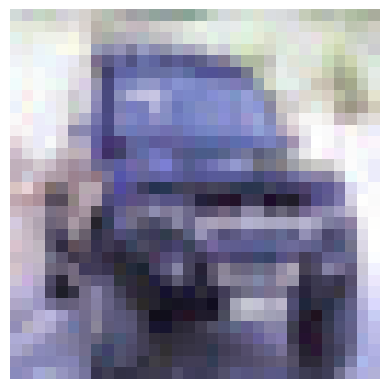

Label of the original example: automobile
Label of the adverserial example: truck


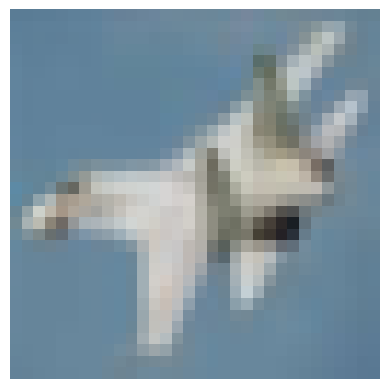

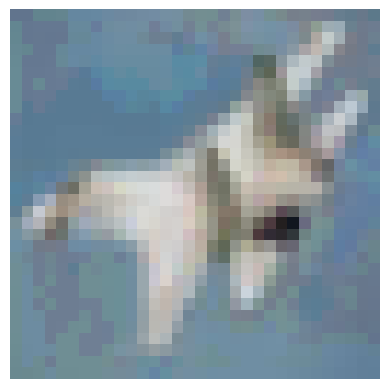

Label of the original example: airplane
Label of the adverserial example: dog


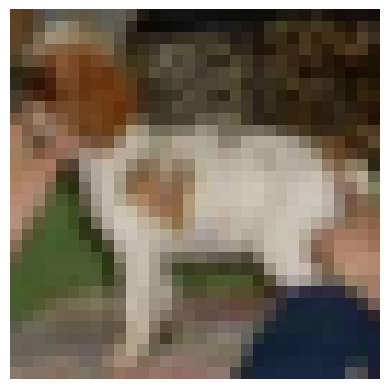

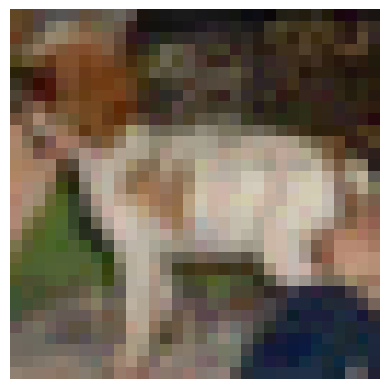

Label of the original example: dog
Label of the adverserial example: deer


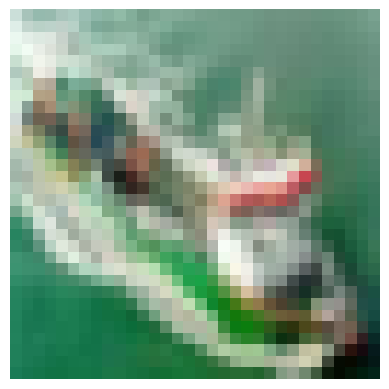

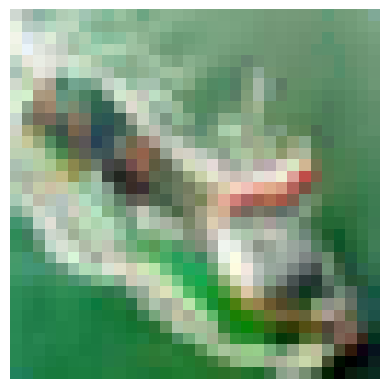

Label of the original example: ship
Label of the adverserial example: bird


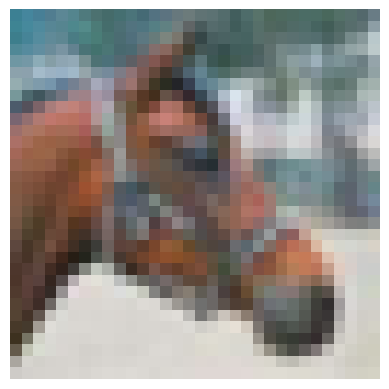

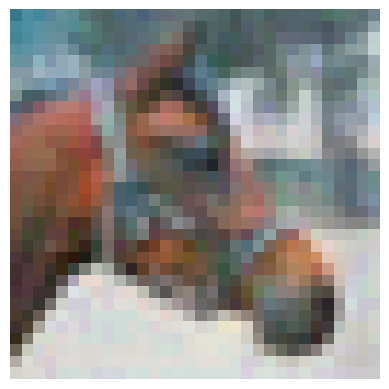

Label of the original example: horse
Label of the adverserial example: cat


In [14]:
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
# load in cifar10 to get what the labels mean so we can interpret the adverserial attacks!
cifar10 = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True)
classes = cifar10.classes

count = 0

for i, sucsessful_attacks in enumerate(adv_examples):
    X, X_adv, Y, Y_hat = sucsessful_attacks
    
    for x, x_adv, y, y_hat in zip(X, X_adv, Y, Y_hat):

        if count == 10: break
        count += 1

        x_permute = x.permute(1, 2, 0)
        x_adv_permute = x_adv.permute(1, 2, 0)

        # Convert the tensor to a NumPy array
        example = x_permute.numpy()
        example_adv = x_adv_permute.numpy()

        # Visualize the image
        plt.imshow(example)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.show()

        plt.imshow(example_adv)
        plt.axis('off')  # Turn off axis numbers and ticks
        plt.show()

        print(f"Label of the original example: {classes[y]}")
        print(f"Label of the adverserial example: {classes[y_hat]}")

### Q5 (10 points)
Which adversarial training algorithm achieves the best robust accuracy in only 25 training epochs? Why do you think that adversarial training algorithm outperforms others? Do you encounter any difficulties when you implement this assignment?

For my training, the training algo that achieves the best robust accuracy is adverserial training. I think that adverserial training outperformed the other adverserial training algorithms because we only trained on 25 epochs. For train_trades, the algorithm trains both on normal training examples as well as adverserial examples with a hyper parameter Beta that balances the emphasis on each. For mixup, the algorithm uses labels that are an interpolation between the 2 existing classes. For both of these methods, they are just harder for the model to learn and probabaly would do very strong if we trained for more epochs. 


The challanges I faced during this assignment were mostly related to the computational graph in pytorch. It can be tricky to make sure that I am correctly sending models and batches to the device and batches are correctly attached and removed from the computational graph in torch. Additionally, it was annoying to have to retrain my model when I did not correctly clamp the RGB values between 0 and 1.

## Submission Instructions

Please submit this  to Canvas, as well as results, as per instructions. 
Please compress `First_Middle_Last_HW1/` into one zip file with the name `First_Middle_Last_HW1.zip` before uploading it to Canvas. The directory contains your notebook and four model checkpoints. As listed below:

- $\texttt{Assignment_2.ipynb}$: your code
- $\texttt{model1.pt}$: your model checkpoint with *natural training* 
- $\texttt{model2.pt}$: your model checkpoint with *adv_train* training
- $\texttt{model3.pt}$: your model checkpoint with *adv_train_trades* training
- $\texttt{model4.pt}$: your model checkpoint with *adv_train_mixup* training

## Academic Integrity

This homework assignment must be done individually. Sharing code or model specifications is strictly prohibited. Homework discussions are allowed only on Piazza, according to the policy outlined on the course web page: [https://canvas.dartmouth.edu/courses/63219](https://canvas.dartmouth.edu/courses/63219). You are not allowed to search online for auxiliary software, reference models, architecture specifications, or additional data to solve the homework assignment. Your submission must be entirely your own work. That is, the code and the answers that you submit must be created, typed, and documented by you alone, based exclusively on the materials discussed in class, and released with the homework assignment. You can obviously consult the class slides posted in Canvas, your lecture notes, and the textbook. Important: the models you will submit for this homework assignment must be
trained exclusively on the specified data provided with this assignment. You can, of course, play with other datasets in your spare time. These rules will be strictly enforced, and any violation will be treated seriously.